## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
from scipy import interpolate
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
from matplotlib.transforms import Bbox
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [37]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

In [38]:
### Load in the necessary single lat AHT files

which_lat1 = 40
which_lat2 = 60

#ddir = 'aht_time_series/one_lat/'
#eddy_files1 = sorted(glob(ddir + 'eddy_total_' + str(which_lat1) +'*'))
#eddy_files2 = sorted(glob(ddir + 'eddy_total_' + str(which_lat2) + '*'))

#eddy_data1 = []
#for eddy in eddy_files1:
    #file_data = np.load(eddy)
    #eddy_data1.append(file_data)

#eddy_local1 = np.concatenate(eddy_data1) * geometry[era_fncts.get_lat_idx(which_lat1)]

#eddy_data2 = []
#for eddy in eddy_files2:
    #file_data = np.load(eddy)
    #eddy_data2.append(file_data)

#eddy_local2 = np.concatenate(eddy_data2) * geometry[era_fncts.get_lat_idx(which_lat2)]

eddy_local_orig1 = xr.open_dataset('aht_time_series/era5_aht_time_series_40deg.nc')
eddy_local_orig2 = xr.open_dataset('aht_time_series/era5_aht_time_series_60deg.nc')

eddy_local1 = era_fncts.get_djf_data(eddy_local_orig1.eddy_aht.values)
eddy_local2 = era_fncts.get_djf_data(eddy_local_orig2.eddy_aht.values)

### Choose whether or not to de-seasonalize the local AHT

In [155]:
#eddy_local1 = eddy_local1
#eddy_local2 = eddy_local2

eddy_local_no_seas1 = np.zeros_like(eddy_local1)
eddy_local_no_seas2 = np.zeros_like(eddy_local2)

for i in range(len(lons)):
    eddy_local_no_seas1[:,i] = era_fncts.remove_seasons_spline(eddy_local1[:,i], periodic=True)[0]
    eddy_local_no_seas2[:,i] = era_fncts.remove_seasons_spline(eddy_local2[:,i], periodic=True)[0]
    
eddy_local1 = eddy_local_no_seas1
eddy_local2 = eddy_local_no_seas2

### Get decorrelation length scale info

In [39]:
decorr_dict = np.load('decorr_dict.npy',allow_pickle='TRUE').item()

decorr_dict_str1 = '40_djf'
decorr_dict_str2 = '60_djf'

try:
    decorr_info1 = decorr_dict[decorr_dict_str1]
except:
    decorr_info1 = era_fncts.decorr_length_scale(eddy_local1)
    decorr_dict[decorr_dict_str1] = decorr_info1

try:
    decorr_info2 = decorr_dict[decorr_dict_str2]
except:
    decorr_info2 = era_fncts.decorr_length_scale(eddy_local2)
    decorr_dict[decorr_dict_str2] = decorr_info2
    
np.save('decorr_dict.npy', decorr_dict) 

### Randomly sample the points

In [40]:
eddy_local1_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local1[:,0])):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(eddy_local1[:,j], 1))
    idx = np.random.randint(len(eddy_local1[:,0]), size=720)
    lon_samples = eddy_local1[idx, range(720)]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_samples[i] = lon_mean
    
eddy_local2_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local2[:,0])):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(eddy_local2[:,j], 1))
    idx = np.random.randint(len(eddy_local2[:,0]), size=720)
    lon_samples = eddy_local2[idx, range(720)]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_samples[i] = lon_mean

### Sample the points based on local correlations

In [41]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

eddy_local1_decor_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local1[:,0])):
    for j in range(720):
        if j % decorr1 == 0: #If its the decorr length scale get a new time
            time_idx = randint(0, len(eddy_local1[:,0])-1)
        else:
            pass
        lon_samples[j] = eddy_local1[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples[i] = lon_mean
    
eddy_local2_decor_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local2[:,0])):
    for j in range(720):
        if j % decorr2 == 0: #If its the decorr length scale get a new time
            time_idx = randint(0, len(eddy_local2[:,0])-1)
        else:
            pass
        lon_samples[j] = eddy_local2[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples[i] = lon_mean

### Plot it!

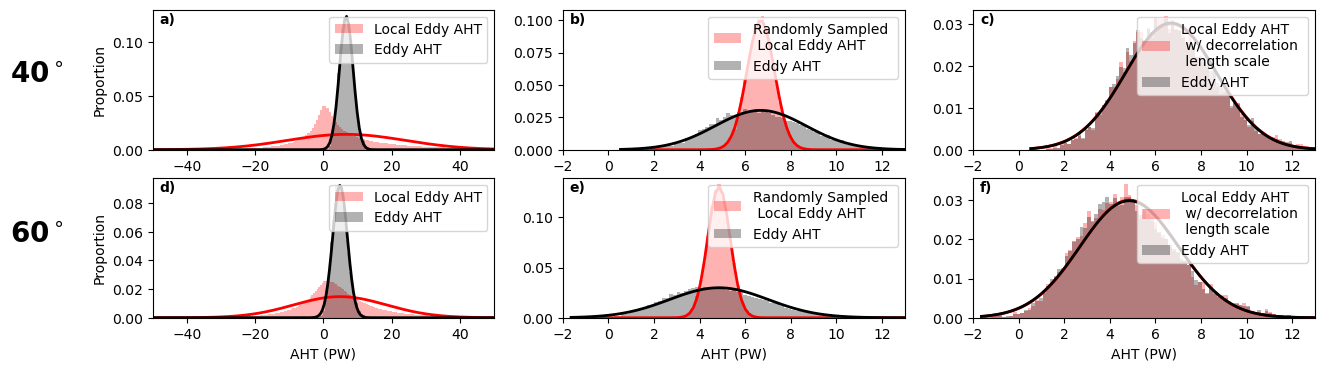

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(15,4))

#eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
#eddy_zonal1 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2).values.flatten()
eddy_zonal1 = era_fncts.get_djf_data(aht_ds.eddy_aht.sel(latitude=which_lat1).values).flatten()
eddy_zonal2 = era_fncts.get_djf_data(aht_ds.eddy_aht.sel(latitude=which_lat2).values).flatten()

local_color = 'r'
zonal_color = 'k'
num_bins1 = 500
num_bins2 = 100

n_bins00, bin_edges00 = np.histogram(eddy_local1.flatten()/1e15, num_bins1)

era_fncts.plot_hist_and_gauss(axs[0,0], eddy_local1.flatten()/1e15, local_color,
                              which_bins=bin_edges00, label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,0], eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges00, label='Eddy AHT')
axs[0,0].legend(loc=1)


n_bins10, bin_edges10 = np.histogram(eddy_local2.flatten()/1e15, num_bins1)

era_fncts.plot_hist_and_gauss(axs[1,0], eddy_local2.flatten()/1e15, local_color,
                              which_bins=bin_edges10, label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,0], eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges10, label='Eddy AHT')

axs[1,0].legend(loc=1)

n_bins01, bin_edges01 = np.histogram(eddy_zonal1/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[0,1], eddy_local1_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges01, label='Randomly Sampled \n Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,1], eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges01, label='Eddy AHT')
axs[0,1].legend(loc=1)

n_bins11, bin_edges11 = np.histogram(eddy_zonal2/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[1,1], eddy_local2_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges11, label='Randomly Sampled \n Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,1], eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges11, label='Eddy AHT')

axs[1,1].legend(loc=1)

n_bins02, bin_edges02 = np.histogram(eddy_zonal1/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[0,2], eddy_local1_decor_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges02, label='Local Eddy AHT \n w/ decorrelation \n length scale')
era_fncts.plot_hist_and_gauss(axs[0,2], eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges02, label='Eddy AHT')
axs[0,2].legend(loc=1)

n_bins12, bin_edges12 = np.histogram(eddy_zonal2/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[1,2], eddy_local2_decor_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges12, label='Local Eddy AHT \n w/ decorrelation \n length scale')
era_fncts.plot_hist_and_gauss(axs[1,2], eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges12, label='Eddy AHT')

axs[1, 2].legend(loc=1)

#plt.suptitle('Comparing local and zonal AHT w/o seasons')

axs[0,0].set_ylabel('Proportion')
axs[1,0].set_ylabel('Proportion')

axs[1,0].set_xlabel('AHT (PW)')
axs[1,1].set_xlabel('AHT (PW)')
axs[1,2].set_xlabel('AHT (PW)')

#axs[0,0].set_yscale('log')
#axs[0,0].set_ylim([1e-6, 1])
#axs[0,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#axs[1,0].set_yscale('log')
#axs[1,0].set_ylim([1e-6, 1])
#axs[1,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])

axs[0,0].set_xlim([-50, 50])
axs[1,0].set_xlim([-50, 50])
axs[0,1].set_xlim([-2, 13])
axs[1,1].set_xlim([-2, 13])
axs[0,2].set_xlim([-2, 13])
axs[1,2].set_xlim([-2, 13])

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for idx, ax in enumerate(axs.flatten()):
    ax.text(x=0.02, y=0.9, s=subplot_labels[idx], transform=ax.transAxes, fontweight='bold')
    
fig.text(x=.03, y=0.7, s='40$^\circ$', fontsize=20, fontweight='bold')
fig.text(x=.03, y=0.3, s='60$^\circ$', fontsize=20, fontweight='bold')

#plt.savefig('figures/4_12_22_meeting/local_zonal_aht_comparisons_djf_norm_scale')

plt.show()